##Loan Approval Prediction Model##

In [1]:
# Importing Data Manipulation Libraries
import pandas as pd
import numpy as np
# Import Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt 
# Import Filter Warning Libraries
import warnings
warnings.filterwarnings('ignore')
# Import Logging
import logging
logging.basicConfig(level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s',
                    filemode = 'w',
                    filename = 'model.log',force = True)
# Import Scikit Learn Libraries for Machine Learning Model Building
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import xgboost
from sklearn.cluster import KMeans


# Multicolinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#3. Import OrderDict()
from collections import OrderedDict

In [ ]:
filepath = "Data/credit-risk-data.csv"
df = pd.read_csv(filepath)
df.head()

,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,EmploymentStatus,MaritalStatus,NumberOfDependents,EducationLevel,HomeOwnershipStatus,...,JobTenure,MonthlySavings,AnnualBonuses,AnnualExpenses,MonthlyHousingCosts,MonthlyTransportationCosts,MonthlyFoodCosts,MonthlyHealthcareCosts,MonthlyEntertainmentCosts,LoanApproved
0,402,63295,18830,13,29,Self-Employed,Widowed,2,Doctorate,Other,...,24,378,3741,40058,977,412,399,136,124,0
1,735,55936,23729,1,42,Self-Employed,Divorced,3,Master,Own,...,10,575,4115,16745,695,206,898,252,131,0
2,570,62547,19660,7,54,Self-Employed,Single,3,Doctorate,Mortgage,...,16,691,4105,23273,627,266,392,73,36,0
3,406,46129,21674,23,25,Self-Employed,Divorced,3,High School,Other,...,6,452,4559,42163,397,307,250,378,-32,0
4,371,57725,12189,26,42,Employed,Widowed,4,Master,Own,...,2,690,7856,30087,723,315,114,88,68,0


In [ ]:
# Descriptive stats

def descriptive_stats():
    numerical_col = df.select_dtypes(exclude = 'object').columns                                               #segregating
    categorica_col = df.select_dtypes(include = 'object').columns
    num_stats = []
    cat_stats = []
    data_info = []

    for i in numerical_col:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1 
        LF = Q1 - 1.5*IQR
        UF = Q3 + 1.5*IQR

        outlier_count = len(df[(df[i] < LF) | (df[i] > UF)])
        outlier_percentage = outlier_count / len(df[i]) * 100

        numerical_stats = OrderedDict({
            "Feature " : i ,
            "Q1" : Q1,
            "Q3" : Q3,
            "IQR" : IQR,
            "LF" : LF,
            "UF" : UF,
            "Mean" : df[i].mean(),
            "Median" : df[i].median(),
            "Min" : df[i].min(),
            "Max" : df[i].max(),
            "Outlier count" : outlier_count,
            "outlier percentage" : outlier_percentage,
            "standard derivation": df[i].std(),
            "variance" : df[i].var(),
            "skewness" : df[i].skew(),
            "kurtosis" : df[i].kurtosis()
        })
        num_stats.append(numerical_stats)
    numerical_stats_report = pd.DataFrame(num_stats)

    for i in categorica_col:
        categorical_stats = OrderedDict({
            "Feature" : i , 
            "Unquie count" : df[i].nunique(),
            "Value count" : df[i].value_counts(),
            "mode" : df[i].mode()
        })
        cat_stats.append(categorical_stats)
    categorical_stats_report = pd.DataFrame(cat_stats)


    for i in df.columns : 
        data1 = OrderedDict({
            "Feature" : i ,
            "Missing value" : df[i].isnull().sum(),
            "Unqiue value" : df[i].nunique(),
            "value count " : df[i].value_counts().to_dict()
        })
        data_info.append(data1)
    data_info_report = pd.DataFrame(data_info)

    return categorical_stats_report,numerical_stats_report,data_info_report

categorical_stats_report,numerical_stats_report,data_info_report = descriptive_stats()

In [4]:
numerical_stats_report

,Feature,Q1,Q3,IQR,LF,UF,Mean,Median,Min,Max,Outlier count,outlier percentage,standard derivation,variance,skewness,kurtosis
0,CreditScore,437.000000,712.000000,275.000000,24.500000,1124.500000,574.423520,574.000000,300.000000,849.000000,0,0.000,158.751086,2.520191e+04,0.001973,-1.198059
1,AnnualIncome,49874.000000,70114.000000,20240.000000,19514.000000,100474.000000,59998.984440,59957.000000,1263.000000,118054.000000,737,0.737,14995.177544,2.248553e+08,0.000014,-0.012020
2,LoanAmount,16614.000000,23369.000000,6755.000000,6481.500000,33501.500000,19996.252480,19986.000000,-348.000000,40423.000000,694,0.694,5017.365491,2.517396e+07,0.001516,-0.016734
3,LoanDuration,8.000000,22.000000,14.000000,-13.000000,43.000000,15.026640,15.000000,1.000000,29.000000,0,0.000,8.376726,7.016953e+01,-0.004112,-1.205910
4,Age,30.000000,56.000000,26.000000,-9.000000,95.000000,43.417450,43.000000,18.000000,69.000000,0,0.000,14.982679,2.244807e+02,0.010035,-1.198233
5,NumberOfDependents,1.000000,3.000000,2.000000,-2.000000,6.000000,1.997240,2.000000,0.000000,4.000000,0,0.000,1.417841,2.010272e+00,0.000051,-1.305371
6,MonthlyDebtPayments,366.000000,635.000000,269.000000,-37.500000,1038.500000,499.911360,499.000000,-402.000000,1378.000000,726,0.726,199.988611,3.999544e+04,0.005237,0.016336
7,CreditCardUtilizationRate,0.251575,0.750752,0.499176,-0.497189,1.499517,0.500778,0.501393,0.000014,0.999997,0,0.000,0.288493,8.322814e-02,-0.002672,-1.198389
8,NumberOfOpenCreditLines,3.000000,11.000000,8.000000,-9.000000,23.000000,6.998870,7.000000,0.000000,14.000000,0,0.000,4.319747,1.866022e+01,-0.001191,-1.214230
9,NumberOfCreditInquiries,2.000000,7.000000,5.000000,-5.500000,14.500000,4.510750,5.000000,0.000000,9.000000,0,0.000,2.872679,8.252287e+00,-0.003135,-1.227823


In [5]:
categorical_stats_report

,Feature,Unquie count,Value count,mode
0,EmploymentStatus,3,EmploymentStatus Employed 33488 Self-E...,"0 Employed Name: EmploymentStatus, dtype: o..."
1,MaritalStatus,4,MaritalStatus Married 25226 Divorced 24...,"0 Married Name: MaritalStatus, dtype: object"
2,EducationLevel,5,EducationLevel Associate 20153 High Schoo...,"0 Associate Name: EducationLevel, dtype: ob..."
3,HomeOwnershipStatus,4,HomeOwnershipStatus Mortgage 25168 Own ...,"0 Mortgage Name: HomeOwnershipStatus, dtype..."
4,LoanPurpose,5,LoanPurpose Education 20120 Home ...,"0 Education Name: LoanPurpose, dtype: object"
5,HealthInsuranceStatus,2,HealthInsuranceStatus Insured 50042 Unins...,"0 Insured Name: HealthInsuranceStatus, dtyp..."
6,LifeInsuranceStatus,2,LifeInsuranceStatus Uninsured 50031 Insured...,"0 Uninsured Name: LifeInsuranceStatus, dtyp..."
7,CarInsuranceStatus,2,CarInsuranceStatus Insured 50163 Uninsure...,"0 Insured Name: CarInsuranceStatus, dtype: ..."
8,HomeInsuranceStatus,2,HomeInsuranceStatus Uninsured 50214 Insured...,"0 Uninsured Name: HomeInsuranceStatus, dtyp..."
9,EmployerType,4,EmployerType Private 25240 Other ...,"0 Private Name: EmployerType, dtype: object"


In [6]:
data_info_report

,Feature,Missing value,Unqiue value,value count
0,CreditScore,0,550,"{675: 221, 656: 216, 829: 216, 584: 215, 448: ..."
1,AnnualIncome,0,48065,"{56031: 12, 58552: 11, 56208: 10, 58777: 10, 6..."
2,LoanAmount,0,22395,"{21448: 21, 21369: 21, 20813: 20, 19360: 18, 1..."
3,LoanDuration,0,29,"{16: 3528, 28: 3523, 4: 3521, 14: 3506, 23: 34..."
4,Age,0,52,"{33: 2020, 31: 2011, 26: 2009, 21: 1982, 57: 1..."
5,EmploymentStatus,0,3,"{'Employed': 33488, 'Self-Employed': 33347, 'U..."
6,MaritalStatus,0,4,"{'Married': 25226, 'Divorced': 24988, 'Single'..."
7,NumberOfDependents,0,5,"{0: 20273, 4: 20044, 3: 19970, 2: 19925, 1: 19..."
8,EducationLevel,0,5,"{'Associate': 20153, 'High School': 20122, 'Ba..."
9,HomeOwnershipStatus,0,4,"{'Mortgage': 25168, 'Own': 25037, 'Rent': 2498..."


In [7]:
df.columns

Index(['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age',
       'EmploymentStatus', 'MaritalStatus', 'NumberOfDependents',
       'EducationLevel', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'InterestRate', 'PaymentHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance',
       'InvestmentAccountBalance', 'RetirementAccountBalance',
       'EmergencyFundBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
       'LengthOfCreditHistory', 'MortgageBalance', 'RentPayments',
       'AutoLoanBalance', 'PersonalLoanBalance', 'StudentLoanBalance',
       'UtilityBillsPaymentHistory', 'HealthInsuranceStatus',
       'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus',
       'OtherInsurancePolicies', 'EmployerType', 'JobTenure', 'MonthlySavings',
       'AnnualB

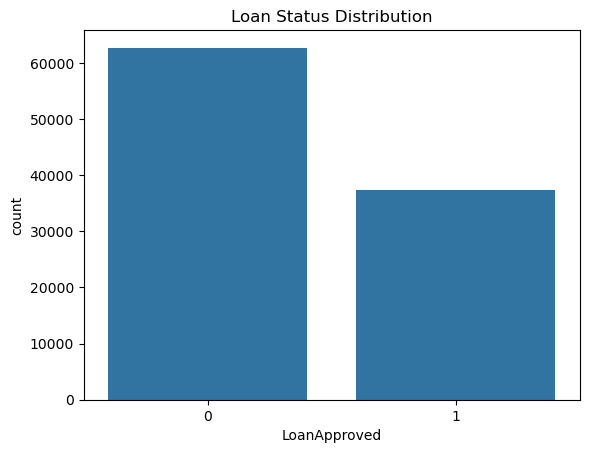

In [8]:
sns.countplot(x='LoanApproved', data=df)
plt.title('Loan Status Distribution')
plt.show()

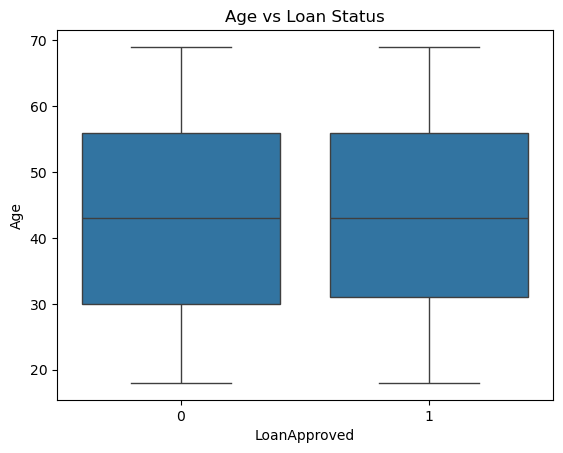

In [9]:
sns.boxplot(x='LoanApproved', y='Age', data=df)
plt.title('Age vs Loan Status')
plt.show()

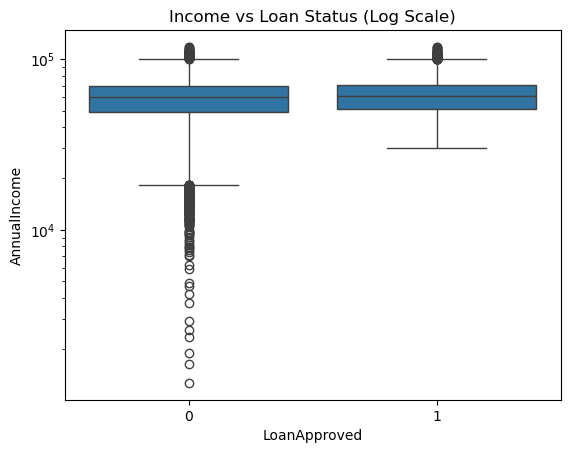

In [10]:
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df)
plt.yscale('log')   # IMPORTANT since data is non-normal
plt.title('Income vs Loan Status (Log Scale)')
plt.show()

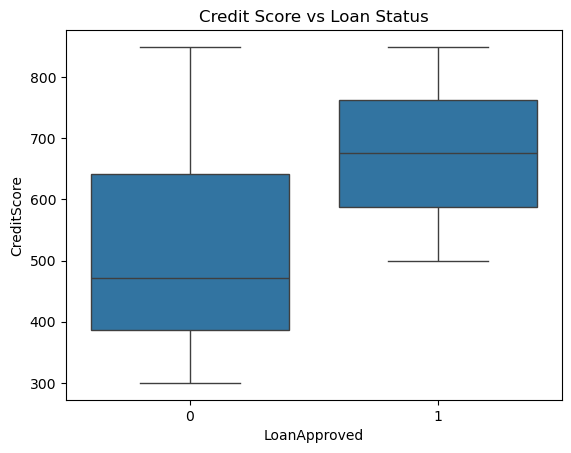

In [11]:
sns.boxplot(x='LoanApproved', y='CreditScore', data=df)
plt.title('Credit Score vs Loan Status')
plt.show()

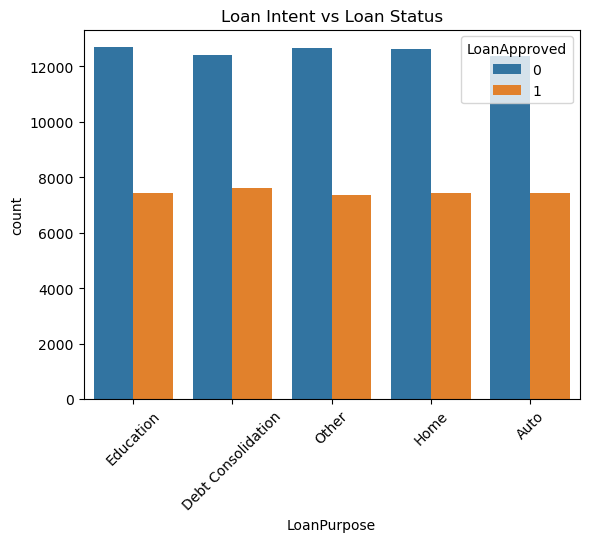

In [12]:
sns.countplot(x='LoanPurpose', hue='LoanApproved', data=df)
plt.xticks(rotation=45)
plt.title('Loan Intent vs Loan Status')
plt.show()

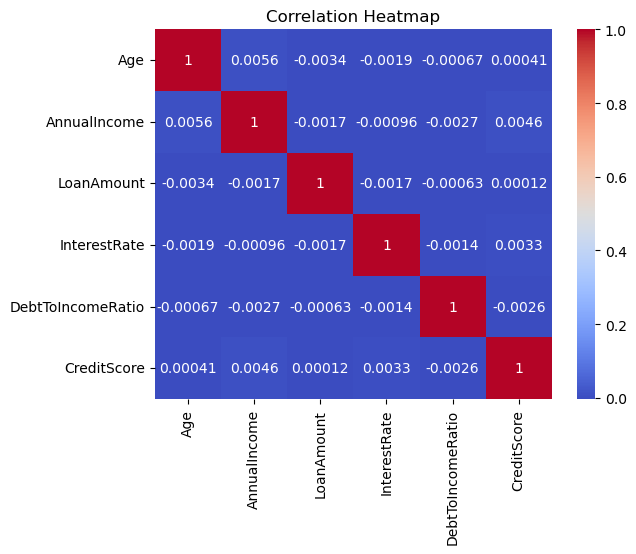

In [13]:
num_cols = [
    'Age', 'AnnualIncome',
    'LoanAmount', 'InterestRate', 'DebtToIncomeRatio',
    'CreditScore'
]

sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# train test split
from sklearn.model_selection import train_test_split 

X = df.drop(columns= 'LoanApproved',axis = 1)
y = df['LoanApproved']

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size= 0.3 , random_state= 42)

In [15]:
# Encoding & scalling
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer

categorical_cols  = X.select_dtypes(include= 'object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(),numerical_cols),
        ('cat' , OneHotEncoder(handle_unknown='ignore') ,categorical_cols)
    ]

)

# apply transformation
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def model_build(X_train, X_test, y_train, y_test):

    models = {
        'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
        'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10, weights='distance')
    }

    model_performance = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        model_performance.append({
            'Model_Name': model_name,
            'Accuracy_Score': accuracy_score(y_test, y_pred),
            'Confusion_Matrix': confusion_matrix(y_test, y_pred),
            'Classification_Report': classification_report(y_test, y_pred, output_dict=False)
        })

    return pd.DataFrame(model_performance)

In [17]:
model_performance = model_build(X_train,X_test,y_train,y_test)
model_performance

,Model_Name,Accuracy_Score,Confusion_Matrix,Classification_Report
0,LogisticRegression,0.709633,"[[13204, 5595], [3116, 8085]]",precision recall f1-score ...
1,DecisionTreeClassifier,0.695333,"[[14485, 4314], [4826, 6375]]",precision recall f1-score ...
2,RandomForestClassifier,0.727900,"[[12857, 5942], [2221, 8980]]",precision recall f1-score ...
3,GradientBoostingClassifier,0.751767,"[[11389, 7410], [37, 11164]]",precision recall f1-score ...
4,AdaBoostClassifier,0.752067,"[[11361, 7438], [0, 11201]]",precision recall f1-score ...
5,KNeighborsClassifier,0.638733,"[[14736, 4063], [6775, 4426]]",precision recall f1-score ...
